### RNN Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("datasets/Google_Stock_Price_Train.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
df.shape

(1258, 6)

In [4]:
data = df.iloc[:, 1:2].values  # take only 2nd Column "Open"
data

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale data to be between 0 and 1

data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [6]:
# Generate data such that x_train gets previous 60 data points (3 months)
# and y_train gets the 60th data point

x_train = []
y_train = []

for idx in range(60, df.shape[0]):
    x_train.append(data_scaled[idx-60:idx, 0]) 
    y_train.append(data_scaled[idx, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape

(1198, 60)

In [7]:
# Reshape x_train from 2D to 3D as required by LSTM layer (batch_size, timestep, input_dim)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(1198, 60, 1)

In [8]:
# Sequential model with 1 input layer, 7 hidden layers, output layer

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_absolute_error")

In [9]:
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [11]:
df_test = pd.read_csv("datasets/Google_Stock_Price_Test.csv")
df_test.shape

(20, 6)

In [13]:
data_test = df_test.iloc[:, 1:2].values  # take only 2nd Column "Open"

In [22]:
df_total = pd.concat((df["Open"], df_test["Open"]), axis=0)

data_total = df_total[len(df_total) - len(df_test) - 60:].values

data_total = data_total.reshape(-1, 1)

data_total = scaler.transform(data_total)

In [25]:
x_test = []

for idx in range(60, data_total.shape[0]):
    x_test.append(data_total[idx-60:idx, 0]) 

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
predicted_stock_price = model.predict(x_test)
real_predictions = scaler.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 1s/step


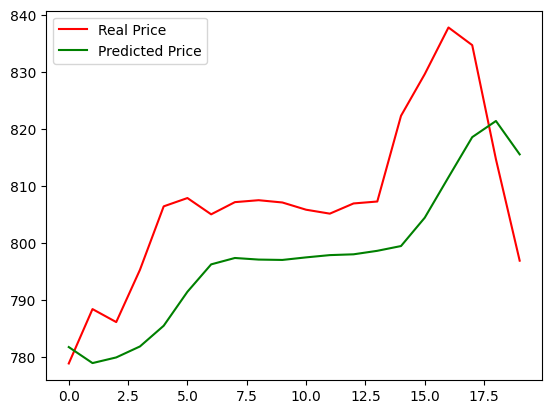

In [28]:
plt.plot(data_test, color="red", label="Real Price")
plt.plot(real_predictions, color="green", label="Predicted Price")
plt.legend()